# Introdução

O futebol é um dos esportes mais jogados e assistidos no mundo inteiro. No Brasil, especialmente, é um símbolo cultural, com pessoas separando horários do seu dia para dedicarem a assistir ou a jogar, além do impacto que o esporte tem na vida de diversas crianças e nas periferias.

Um dos maiores campeonatos no Brasil é o Brasileirão, clássico da história do futebol brasileiro.

O intuito do projeto é analisar um banco de dados com os resultados e estatísticas do Brasileirão e descobrir a quantidade de público em um jogo e/ou analisar quantos chutes para fora do campo os times realizaram baseado nas estatísticas de cada time e jogo.

Essa análise será possível por meio de uma análise exploratória dos dados disponíveis, com um modelo de predição para cada utilizando regressão múltipla. Ao longo desse notebook, será possível visualizar não apenas graficamente os resultados das correlações entre os dados, mas também diversos gráficos de dispersão utilizando a biblioteca Seaborn.

Para iniciar, vamos importar as bibliotecas necessárias e definir o número de linhas que o Pandas mostrará em cada DataFrame.

In [36]:
import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
import statsmodels.api as sm
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

# Para ter melhor print
from IPython.display import display

import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', 10)

Após isso, abriremos o nosso Excel com os dados.

Antes de iniciar a análise, os dados foram organizados em ordem cronológica para uma análise superficial. 

In [3]:
df = pd.read_excel("Projeto2.xlsx")
df.head(5)

ano_campeonato        data  rodada                             estadio  \
0            2003  2003-03-29       1                    Arena da Baixada   
1            2003  2003-03-29       1  Estádio Brinco de Ouro da Princesa   
2            2003  2003-03-30       1              Estádio Alfredo Jaconi   
3            2003  2003-03-30       1             Estádio Manoel Barradas   
4            2003  2003-03-30       1             Estádio Heriberto Hülse   

  arbitro  publico  publico_max time_mandante  time_visitante  \
0     NaN      NaN          NaN   Atlético-PR          Grêmio   
1     NaN      NaN          NaN       Guarani   Vasco da Gama   
2     NaN      NaN          NaN     Juventude       São Paulo   
3     NaN      NaN          NaN    EC Vitória  Figueirense FC   
4     NaN      NaN          NaN   Criciúma EC      Fluminense   

  tecnico_mandante  ... chutes_bola_parada_mandante  \
0              NaN  ...                         NaN   
1              NaN  ...                         NaN   
2              NaN  ...                         NaN   
3              NaN  ...                         NaN   
4              NaN  ...                         NaN   

   chutes_bola_parada_visitante  defesas_mandante  defesas_visitante  \
0                           NaN               NaN                NaN   
1                           NaN               NaN                NaN   
2                           NaN               NaN                NaN   
3                           NaN               NaN                NaN   
4                           NaN               NaN                NaN   

   impedimentos_mandante  impedimentos_visitante  chutes_mandante  \
0                    NaN                     NaN              NaN   
1                    NaN                     NaN              NaN   
2                    NaN                     NaN              NaN   
3                    NaN                     NaN              NaN   
4                    NaN                     NaN              NaN   

   chutes_visitante  chutes_fora_mandante  chutes_fora_visitante  
0               NaN                   NaN                    NaN  
1               NaN                   NaN                    NaN  
2               NaN                   NaN                    NaN  
3               NaN                   NaN                    NaN  
4               NaN                   NaN                    NaN  

[5 rows x 35 columns]

Das variáveis presentes no DataFrame, existem algumas que são quantitativas e outras que são qualitativas.

Das quantitativas, temos:

- Ano do campeonato;
- Data;
- Rodada;
- Público;
- Colocações;
- Estatísticas do time e da partida.

Das qualitativas, temos:

- Estádio;
- Times no jogo;
- Técnicos dos times;
- Árbitro.

Para referências futuras, iremos definir agora a função de regressão múltipla apresentada em sala de aula, na aula 25 de Ciência dos Dados do Insper.

In [7]:
def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

# **Completando o DataFrame**

O DataFrame selecionado com os dados do Brasileirão é bem extenso, mas ainda tem algumas informações básicas que estão faltando, como o ganhador de cada rodada. Para melhorar a visualização do DataFrame e expandir seus dados, é preciso criar uma coluna com os ganhadores de cada rodada.

Vamos, então, montar um DataFrame com as rodadas e os gols obtidos por cada time nessas rodadas.

In [8]:
df_gols = df.loc[:, ['ano_campeonato','data','rodada','estadio','time_mandante','time_visitante','gols_mandante','gols_visitante']]
df_gols

ano_campeonato        data  rodada                             estadio  \
0               2003  2003-03-29       1                    Arena da Baixada   
1               2003  2003-03-29       1  Estádio Brinco de Ouro da Princesa   
2               2003  2003-03-30       1              Estádio Alfredo Jaconi   
3               2003  2003-03-30       1             Estádio Manoel Barradas   
4               2003  2003-03-30       1             Estádio Heriberto Hülse   
...              ...         ...     ...                                 ...   
8029            2023  2023-09-28      22     Estádio Cícero Pompeu de Toledo   
8030            2023  2023-09-30      25                      Arena Pantanal   
8031            2023  2023-09-30      25      Estádio Jornalista Mário Filho   
8032            2023  2023-09-30      25     Estádio Cícero Pompeu de Toledo   
8033            2023  2023-09-30      25  Estádio Governador Plácido Castelo   

     time_mandante  time_visitante  gols_mandante  gols_visitante  
0      Atlético-PR          Grêmio            2.0             0.0  
1          Guarani   Vasco da Gama            4.0             2.0  
2        Juventude       São Paulo            2.0             2.0  
3       EC Vitória  Figueirense FC            1.0             1.0  
4      Criciúma EC      Fluminense            2.0             0.0  
...            ...             ...            ...             ...  
8029     São Paulo     Coritiba FC            2.0             1.0  
8030     Cuiabá-MT      Fluminense            3.0             0.0  
8031      Flamengo        EC Bahia            1.0             0.0  
8032     São Paulo     Corinthians            2.0             1.0  
8033     Fortaleza          Grêmio            1.0             1.0  

[8034 rows x 8 columns]

Para definir os ganhadores de cada partida, iremos montar uma lista com o nome de cada um dos times ganhadores em cada jogo. Para simplificação,  foi adotada a seguinte forma:

- O time com mais gols ganha;
- Se houver empate, não há ganhadores.

In [9]:
victory = []
gol_m = []
gol_v = []
time_m = []
time_v = []

for gols in df_gols['gols_mandante']:
    gol_m.append(gols)
for gols in df_gols['gols_visitante']:
    gol_v.append(gols)
for time in df_gols['time_mandante']:
    time_m.append(time)
for time in df_gols['time_visitante']:
    time_v.append(time)

i = 0
while i < len(gol_m):
    if gol_m[i] > gol_v[i]:
        victory.append(time_m[i])
    elif gol_v[i] > gol_m[i]:
        victory.append(time_v[i])
    elif gol_m[i] == gol_v[i]:
        victory.append('nenhum')
    i += 1

if len(victory) < 8034:
    print("Existe uma ou mais linhas sem dados.")
    print(f"O tamanho deveria ser 8034, mas é {len(victory)}.")
else:
    df_gols['ganhador'] = victory
    df_gols

Existe uma ou mais linhas sem dados.
O tamanho deveria ser 8034, mas é 8033.


Observamos que uma das linhas dos DataFrame dos gols não possui informações, então, mudamos o que o condicional aplica na lista de times vitoriosos. 

Essa mudança será feita por colocar como "faltam dados" a linha em que não há informações.

In [10]:
victory = []
gol_m = []
gol_v = []
time_m = []
time_v = []

for gols in df_gols['gols_mandante']:
    gol_m.append(gols)
for gols in df_gols['gols_visitante']:
    gol_v.append(gols)
for time in df_gols['time_mandante']:
    time_m.append(time)
for time in df_gols['time_visitante']:
    time_v.append(time)

i = 0
while i < len(gol_m):
    if gol_m[i] > gol_v[i]:
        victory.append(time_m[i])
    elif gol_v[i] > gol_m[i]:
        victory.append(time_v[i])
    elif gol_m[i] == gol_v[i]:
        victory.append('nenhum')
    else:
        victory.append('faltam dados')
    i += 1

df_gols['ganhador'] = victory
df_gols

ano_campeonato        data  rodada                             estadio  \
0               2003  2003-03-29       1                    Arena da Baixada   
1               2003  2003-03-29       1  Estádio Brinco de Ouro da Princesa   
2               2003  2003-03-30       1              Estádio Alfredo Jaconi   
3               2003  2003-03-30       1             Estádio Manoel Barradas   
4               2003  2003-03-30       1             Estádio Heriberto Hülse   
...              ...         ...     ...                                 ...   
8029            2023  2023-09-28      22     Estádio Cícero Pompeu de Toledo   
8030            2023  2023-09-30      25                      Arena Pantanal   
8031            2023  2023-09-30      25      Estádio Jornalista Mário Filho   
8032            2023  2023-09-30      25     Estádio Cícero Pompeu de Toledo   
8033            2023  2023-09-30      25  Estádio Governador Plácido Castelo   

     time_mandante  time_visitante  gols_mandante  gols_visitante     ganhador  
0      Atlético-PR          Grêmio            2.0             0.0  Atlético-PR  
1          Guarani   Vasco da Gama            4.0             2.0      Guarani  
2        Juventude       São Paulo            2.0             2.0       nenhum  
3       EC Vitória  Figueirense FC            1.0             1.0       nenhum  
4      Criciúma EC      Fluminense            2.0             0.0  Criciúma EC  
...            ...             ...            ...             ...          ...  
8029     São Paulo     Coritiba FC            2.0             1.0    São Paulo  
8030     Cuiabá-MT      Fluminense            3.0             0.0    Cuiabá-MT  
8031      Flamengo        EC Bahia            1.0             0.0     Flamengo  
8032     São Paulo     Corinthians            2.0             1.0    São Paulo  
8033     Fortaleza          Grêmio            1.0             1.0       nenhum  

[8034 rows x 9 columns]

Para esse caso, a linha que não possui informações de gol foi marcada com a string 'faltam dados'. Portanto, das 8034 linhas, apenas uma possui essa string.

Agora, vamos achar a linha que não possui gols e eliminá-la do nosso DataFrame.

In [11]:
df_gols = df_gols.loc[df_gols['ganhador'] != 'faltam dados']
df_gols

ano_campeonato        data  rodada                             estadio  \
0               2003  2003-03-29       1                    Arena da Baixada   
1               2003  2003-03-29       1  Estádio Brinco de Ouro da Princesa   
2               2003  2003-03-30       1              Estádio Alfredo Jaconi   
3               2003  2003-03-30       1             Estádio Manoel Barradas   
4               2003  2003-03-30       1             Estádio Heriberto Hülse   
...              ...         ...     ...                                 ...   
8029            2023  2023-09-28      22     Estádio Cícero Pompeu de Toledo   
8030            2023  2023-09-30      25                      Arena Pantanal   
8031            2023  2023-09-30      25      Estádio Jornalista Mário Filho   
8032            2023  2023-09-30      25     Estádio Cícero Pompeu de Toledo   
8033            2023  2023-09-30      25  Estádio Governador Plácido Castelo   

     time_mandante  time_visitante  gols_mandante  gols_visitante     ganhador  
0      Atlético-PR          Grêmio            2.0             0.0  Atlético-PR  
1          Guarani   Vasco da Gama            4.0             2.0      Guarani  
2        Juventude       São Paulo            2.0             2.0       nenhum  
3       EC Vitória  Figueirense FC            1.0             1.0       nenhum  
4      Criciúma EC      Fluminense            2.0             0.0  Criciúma EC  
...            ...             ...            ...             ...          ...  
8029     São Paulo     Coritiba FC            2.0             1.0    São Paulo  
8030     Cuiabá-MT      Fluminense            3.0             0.0    Cuiabá-MT  
8031      Flamengo        EC Bahia            1.0             0.0     Flamengo  
8032     São Paulo     Corinthians            2.0             1.0    São Paulo  
8033     Fortaleza          Grêmio            1.0             1.0       nenhum  

[8033 rows x 9 columns]

Com o comando acima, a linha que não possui dados foi eliminada do nosso DataFrame.

Essa linha, originalmente, era uma linha onde não havia o número de gols. Isso pode indicar duas coisas:

- Não houve jogo;
- Essa informação simplesmente não foi contabilizada.

Independentemente de qual seja o motivo, esse dado foi eliminado para evitar futuros erros.

Agora, vamos adicionar os ganhadores ao nosso DataFrame original.

In [12]:
df['ganhador'] = victory
df

ano_campeonato        data  rodada                             estadio  \
0               2003  2003-03-29       1                    Arena da Baixada   
1               2003  2003-03-29       1  Estádio Brinco de Ouro da Princesa   
2               2003  2003-03-30       1              Estádio Alfredo Jaconi   
3               2003  2003-03-30       1             Estádio Manoel Barradas   
4               2003  2003-03-30       1             Estádio Heriberto Hülse   
...              ...         ...     ...                                 ...   
8029            2023  2023-09-28      22     Estádio Cícero Pompeu de Toledo   
8030            2023  2023-09-30      25                      Arena Pantanal   
8031            2023  2023-09-30      25      Estádio Jornalista Mário Filho   
8032            2023  2023-09-30      25     Estádio Cícero Pompeu de Toledo   
8033            2023  2023-09-30      25  Estádio Governador Plácido Castelo   

                        arbitro  publico  publico_max time_mandante  \
0                           NaN      NaN          NaN   Atlético-PR   
1                           NaN      NaN          NaN       Guarani   
2                           NaN      NaN          NaN     Juventude   
3                           NaN      NaN          NaN    EC Vitória   
4                           NaN      NaN          NaN   Criciúma EC   
...                         ...      ...          ...           ...   
8029      Savio Pereira Sampaio  31720.0      72039.0     São Paulo   
8030      Paulo Cesar Zanovelli   8358.0      42968.0     Cuiabá-MT   
8031      Savio Pereira Sampaio  46472.0      78838.0      Flamengo   
8032  Flavio Rodrigues de Souza  56735.0      72039.0     São Paulo   
8033              Raphael Claus  23634.0      60326.0     Fortaleza   

      time_visitante    tecnico_mandante  ... chutes_bola_parada_visitante  \
0             Grêmio                 NaN  ...                          NaN   
1      Vasco da Gama                 NaN  ...                          NaN   
2          São Paulo                 NaN  ...                          NaN   
3     Figueirense FC                 NaN  ...                          NaN   
4         Fluminense                 NaN  ...                          NaN   
...              ...                 ...  ...                          ...   
8029     Coritiba FC      Dorival Júnior  ...                         12.0   
8030      Fluminense       Toni Oliveira  ...                         16.0   
8031        EC Bahia         Mário Jorge  ...                         11.0   
8032     Corinthians      Dorival Júnior  ...                         11.0   
8033          Grêmio  Juan Pablo Vojvoda  ...                         10.0   

      defesas_mandante  defesas_visitante  impedimentos_mandante  \
0                  NaN                NaN                    NaN   
1                  NaN                NaN                    NaN   
2                  NaN                NaN                    NaN   
3                  NaN                NaN                    NaN   
4                  NaN                NaN                    NaN   
...                ...                ...                    ...   
8029               1.0                3.0                    2.0   
8030               2.0                3.0                    2.0   
8031               4.0                4.0                    1.0   
8032               1.0                6.0                    2.0   
8033               3.0                5.0                    1.0   

      impedimentos_visitante  chutes_mandante  chutes_visitante  \
0                        NaN              NaN               NaN   
1                        NaN              NaN               NaN   
2                        NaN              NaN               NaN   
3                        NaN              NaN               NaN   
4                        NaN              NaN               NaN   
...                      ...        

Você verá, daqui em diante, que os ganhadores e a coluna criada não será utilizada. O intuito dessa criação foi para que, caso haja alguma mudança futura, seja possível analisar os ganhadores de cada partida com base nas funções estabelecidas.

# **Montando a primeira pergunta**

Para realizarmos a análise com Seaborn, vamos pegar apenas as variáveis quantitativas presentes no nosso DataFrame.

In [13]:
df.dtypes

ano_campeonato             int64
data                      object
rodada                     int64
estadio                   object
arbitro                   object
                          ...   
chutes_mandante          float64
chutes_visitante         float64
chutes_fora_mandante     float64
chutes_fora_visitante    float64
ganhador                  object
Length: 36, dtype: object

In [14]:
df_quant = df.select_dtypes(include=('int64','float64'))
df_quant

ano_campeonato  rodada  publico  publico_max  colocacao_mandante  \
0               2003       1      NaN          NaN                 NaN   
1               2003       1      NaN          NaN                 NaN   
2               2003       1      NaN          NaN                 NaN   
3               2003       1      NaN          NaN                 NaN   
4               2003       1      NaN          NaN                 NaN   
...              ...     ...      ...          ...                 ...   
8029            2023      22  31720.0      72039.0                10.0   
8030            2023      25   8358.0      42968.0                11.0   
8031            2023      25  46472.0      78838.0                 5.0   
8032            2023      25  56735.0      72039.0                10.0   
8033            2023      25  23634.0      60326.0                 9.0   

      colocacao_visitante  valor_equipe_titular_mandante  \
0                     NaN                            NaN   
1                     NaN                            NaN   
2                     NaN                            NaN   
3                     NaN                            NaN   
4                     NaN                            NaN   
...                   ...                            ...   
8029                 20.0                     28300000.0   
8030                  6.0                      7800000.0   
8031                 18.0                     79000000.0   
8032                 13.0                     39100000.0   
8033                  3.0                     14500000.0   

      valor_equipe_titular_visitante  idade_media_titular_mandante  \
0                                NaN                           NaN   
1                                NaN                           NaN   
2                                NaN                           NaN   
3                                NaN                           NaN   
4                                NaN                           NaN   
...                              ...                           ...   
8029                      13250000.0                          26.1   
8030                      23950000.0                          29.3   
8031                      24350000.0                          27.8   
8032                      22150000.0                          28.1   
8033                      31350000.0                          29.8   

      idade_media_titular_visitante  ...  chutes_bola_parada_mandante  \
0                               NaN  ...                          NaN   
1                               NaN  ...                          NaN   
2                               NaN  ...                          NaN   
3                               NaN  ...                          NaN   
4                               NaN  ...                          NaN   
...                             ...  ...                          ...   
8029                           31.8  ...                         11.0   
8030                           28.9  ...                         11.0   
8031                           29.1  ...                         13.0   
8032                           28.4  ...                         14.0   
8033                           30.1  ...                         10.0   

      chutes_bola_parada_visitante  defesas_mandante  defesas_visitante  \
0                              NaN               NaN                NaN   
1                              NaN               NaN                NaN   
2                              NaN               NaN                NaN   
3                              NaN               NaN                NaN   
4                              NaN               NaN                NaN   
...                            ...               ...                ...   
8029                          12.0               1.0                3.0   
8030                          16.0               2.0                3.0   
803

O DataFrame acima está mostrando apenas as variáveis quantitativas que serão utilizadas para plotar os gráficos desejados. Das 36 colunas existentes, 28 são quantitativas. Muitas, não é mesmo?

Abaixo, vamos criar o primeiro DataFrame para analisar a primeira questão: descobrir o público com base nos valores combinados dos times.

Essa primeira questão surgiu de uma situação constantemente vista em jogos de futebol transmitidos: geralmente, quando há times mais populares e caros em campo, existe uma tendência de o estádio estar mais cheio. Por exemplo, em um jogo entre Corinthians e Palmeiras, onde os estádios lotam. O intuito dessa primeira questão é de utilizar esses dados entre cada time e analisar a precisão da nossa dedução, utilizando, em tese, os valores como base.

In [15]:
df_first = df_quant.loc[:,['publico','valor_equipe_titular_mandante','valor_equipe_titular_visitante','idade_media_titular_mandante','idade_media_titular_visitante','gols_mandante','gols_visitante']]
df_first

publico  valor_equipe_titular_mandante  valor_equipe_titular_visitante  \
0         NaN                            NaN                             NaN   
1         NaN                            NaN                             NaN   
2         NaN                            NaN                             NaN   
3         NaN                            NaN                             NaN   
4         NaN                            NaN                             NaN   
...       ...                            ...                             ...   
8029  31720.0                     28300000.0                      13250000.0   
8030   8358.0                      7800000.0                      23950000.0   
8031  46472.0                     79000000.0                      24350000.0   
8032  56735.0                     39100000.0                      22150000.0   
8033  23634.0                     14500000.0                      31350000.0   

      idade_media_titular_mandante  idade_media_titular_visitante  \
0                              NaN                            NaN   
1                              NaN                            NaN   
2                              NaN                            NaN   
3                              NaN                            NaN   
4                              NaN                            NaN   
...                            ...                            ...   
8029                          26.1                           31.8   
8030                          29.3                           28.9   
8031                          27.8                           29.1   
8032                          28.1                           28.4   
8033                          29.8                           30.1   

      gols_mandante  gols_visitante  
0               2.0             0.0  
1               4.0             2.0  
2               2.0             2.0  
3               1.0             1.0  
4               2.0             0.0  
...             ...             ...  
8029            2.0             1.0  
8030            3.0             0.0  
8031            1.0             0.0  
8032            2.0             1.0  
8033            1.0             1.0  

[8034 rows x 7 columns]

Uma ocorrência constante nos DataFrames que partem desde 2003 (quando o nosso banco de dados começa) é que há um grande número de informações que não estão presentes, vistas pelo "NaN".

Para que haja uma melhor análise e compreensão dos dados para responder as perguntas, essas informações vão precisar ser eliminadas.

In [16]:
df_nan = df_first.dropna()
df_nan

publico  valor_equipe_titular_mandante  valor_equipe_titular_visitante  \
1713   7801.0                       550000.0                       3750000.0   
1714   5116.0                      1650000.0                        500000.0   
1715  23273.0                      2750000.0                       5350000.0   
1716  12132.0                      7200000.0                       5750000.0   
1718   3568.0                      1000000.0                       1500000.0   
...       ...                            ...                             ...   
8029  31720.0                     28300000.0                      13250000.0   
8030   8358.0                      7800000.0                      23950000.0   
8031  46472.0                     79000000.0                      24350000.0   
8032  56735.0                     39100000.0                      22150000.0   
8033  23634.0                     14500000.0                      31350000.0   

      idade_media_titular_mandante  idade_media_titular_visitante  \
1713                          26.2                           26.7   
1714                          24.6                           26.4   
1715                          26.2                           24.4   
1716                          24.4                           24.1   
1718                          26.5                           24.0   
...                            ...                            ...   
8029                          26.1                           31.8   
8030                          29.3                           28.9   
8031                          27.8                           29.1   
8032                          28.1                           28.4   
8033                          29.8                           30.1   

      gols_mandante  gols_visitante  
1713            2.0             4.0  
1714            2.0             1.0  
1715            4.0             1.0  
1716            2.0             2.0  
1718            3.0             0.0  
...             ...             ...  
8029            2.0             1.0  
8030            3.0             0.0  
8031            1.0             0.0  
8032            2.0             1.0  
8033            1.0             1.0  

[5931 rows x 7 columns]

Com as linhas sem informações deletadas, podemos plotar os dados de correlação e analisá-los utilizando Seaborn.

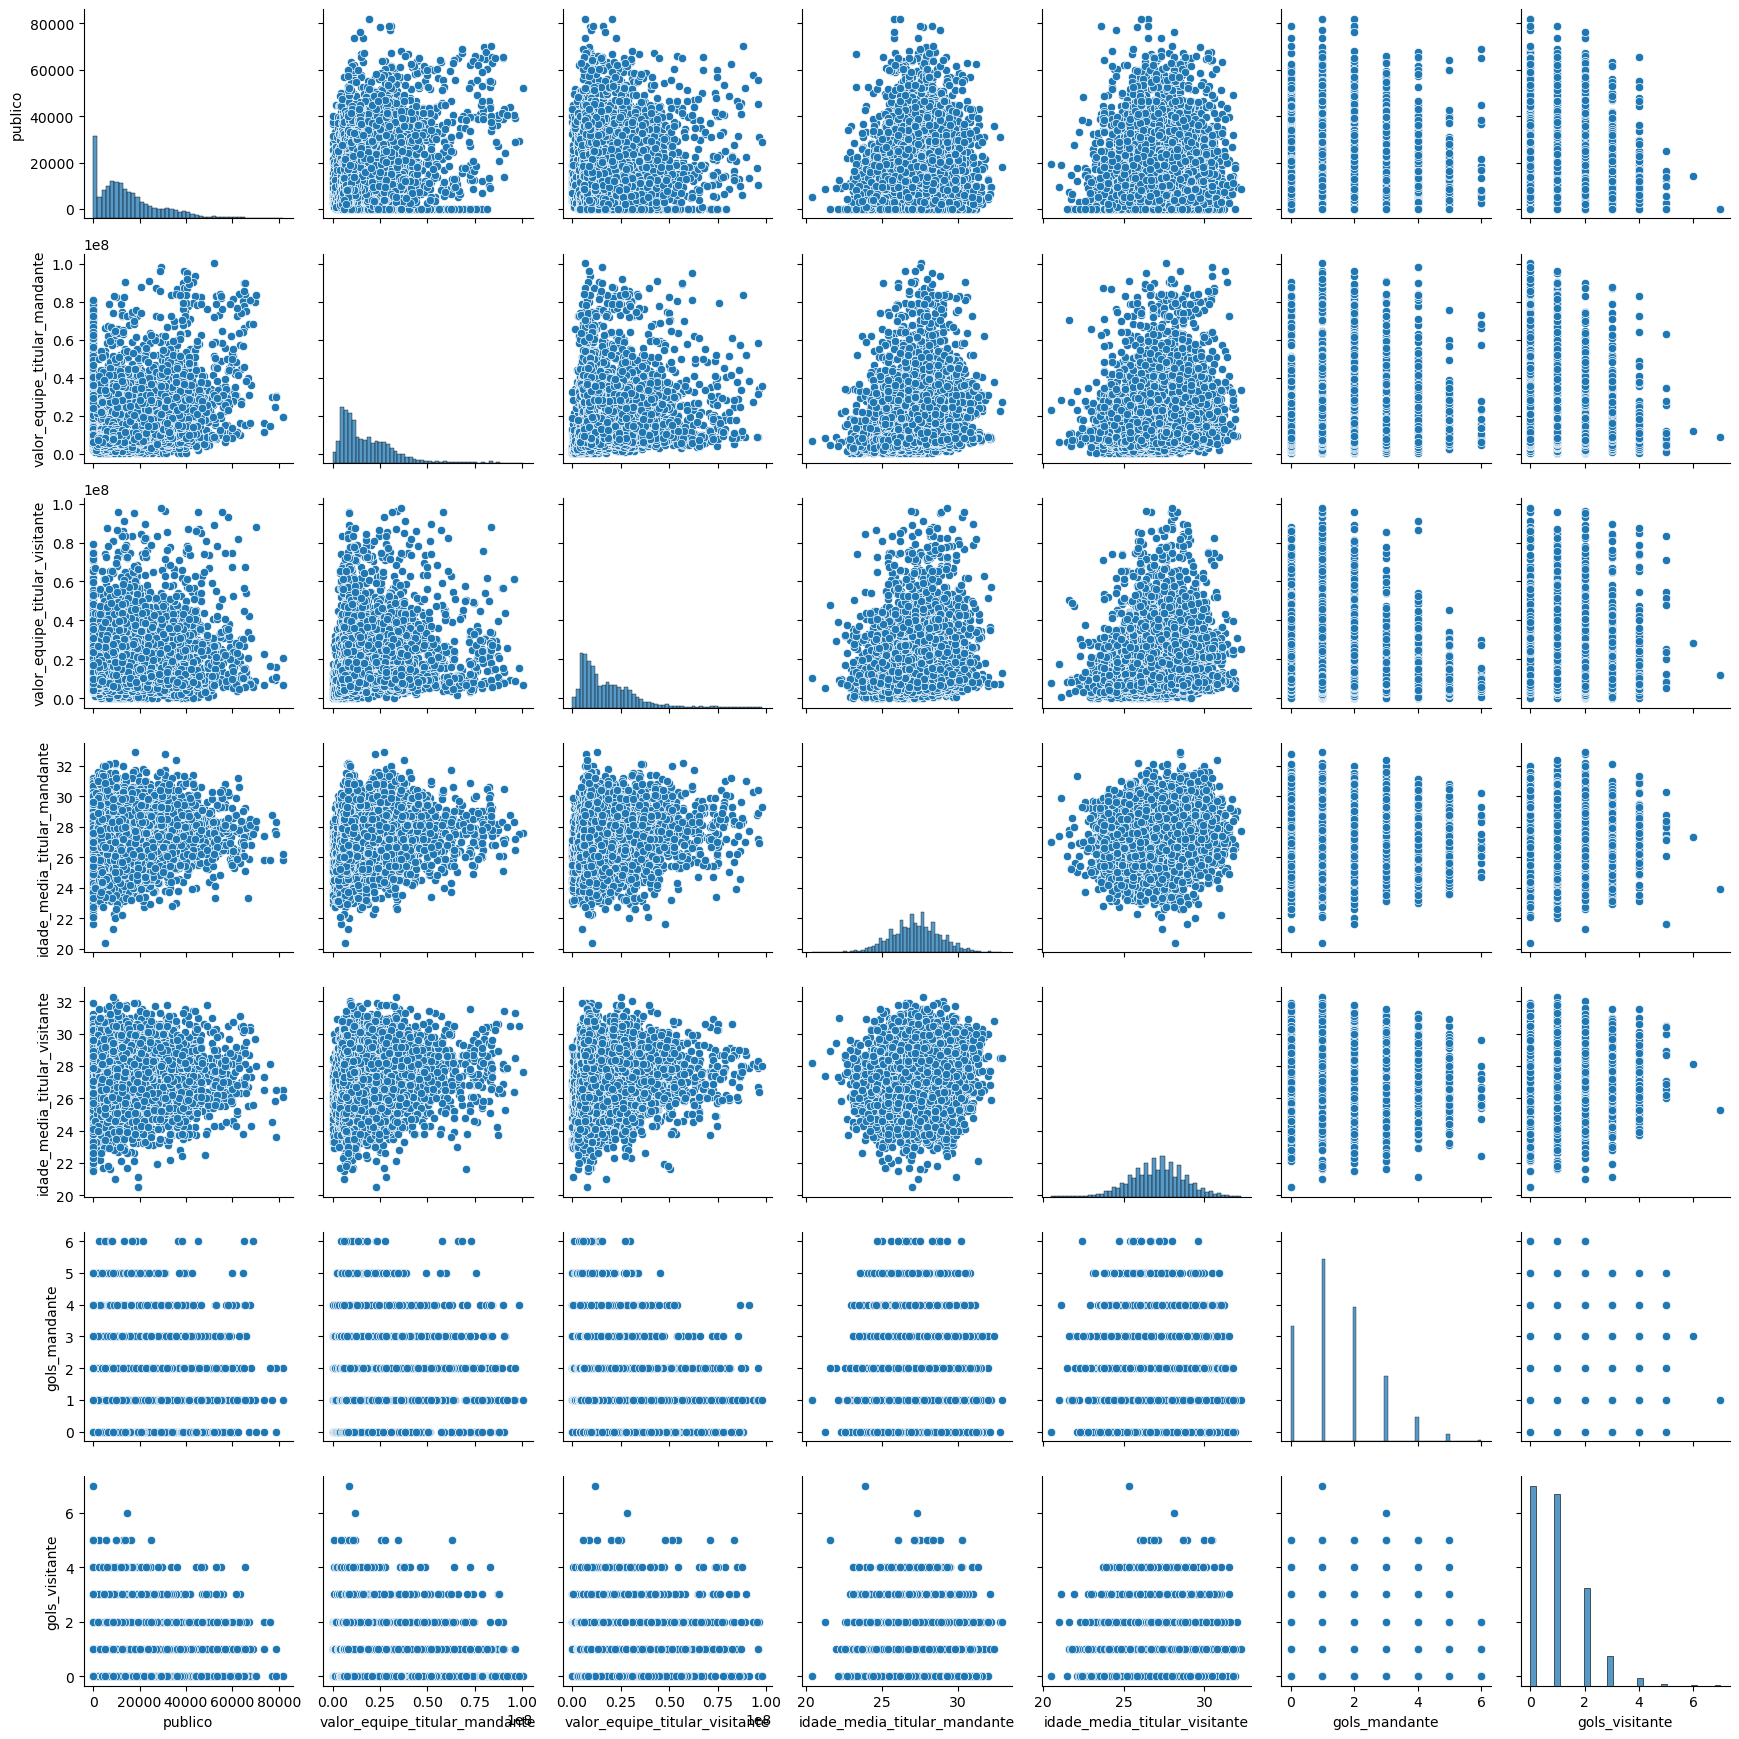

In [17]:
sns.pairplot(df_nan)
plt.tight_layout()
plt.show()

Realizando apenas uma análise visual, é possível perceber que a correlação entre todos os dados que foram selecionados não é alta. Apenas com base nisso, é possível perceber que a nossa análise da primeira pergunta não será muito boa. Porém, vamos realizá-la para entendermos o quão longe da marca estaremos.

Para poder ficar mais fácil de ver os valores, vamos juntar todos os valores de cada time em cada rodada em uma coluna com o valor total dos dois times.

In [18]:
total_value = []
valor_m = []
valor_v = []

for valor in df_nan['valor_equipe_titular_mandante']:
    valor_m.append(valor)
for valor in df_nan['valor_equipe_titular_visitante']:
    valor_v.append(valor)

i = 0
while i < len(valor_m):
    total_value.append(valor_v[i] + valor_m[i])
    i += 1

df_nan['valor_total_times'] = total_value
df_nan    

C:\Users\Victor Cunha\AppData\Local\Temp\ipykernel_19472\2136928414.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan['valor_total_times'] = total_value


publico  valor_equipe_titular_mandante  valor_equipe_titular_visitante  \
1713   7801.0                       550000.0                       3750000.0   
1714   5116.0                      1650000.0                        500000.0   
1715  23273.0                      2750000.0                       5350000.0   
1716  12132.0                      7200000.0                       5750000.0   
1718   3568.0                      1000000.0                       1500000.0   
...       ...                            ...                             ...   
8029  31720.0                     28300000.0                      13250000.0   
8030   8358.0                      7800000.0                      23950000.0   
8031  46472.0                     79000000.0                      24350000.0   
8032  56735.0                     39100000.0                      22150000.0   
8033  23634.0                     14500000.0                      31350000.0   

      idade_media_titular_mandante  idade_media_titular_visitante  \
1713                          26.2                           26.7   
1714                          24.6                           26.4   
1715                          26.2                           24.4   
1716                          24.4                           24.1   
1718                          26.5                           24.0   
...                            ...                            ...   
8029                          26.1                           31.8   
8030                          29.3                           28.9   
8031                          27.8                           29.1   
8032                          28.1                           28.4   
8033                          29.8                           30.1   

      gols_mandante  gols_visitante  valor_total_times  
1713            2.0             4.0          4300000.0  
1714            2.0             1.0          2150000.0  
1715            4.0             1.0          8100000.0  
1716            2.0             2.0         12950000.0  
1718            3.0             0.0          2500000.0  
...             ...             ...                ...  
8029            2.0             1.0         41550000.0  
8030            3.0             0.0         31750000.0  
8031            1.0             0.0        103350000.0  
8032            2.0             1.0         61250000.0  
8033            1.0             1.0         45850000.0  

[5931 rows x 8 columns]

Para ver as correlações visualmente, vamos plotar um novo gráfico do Seaborn.

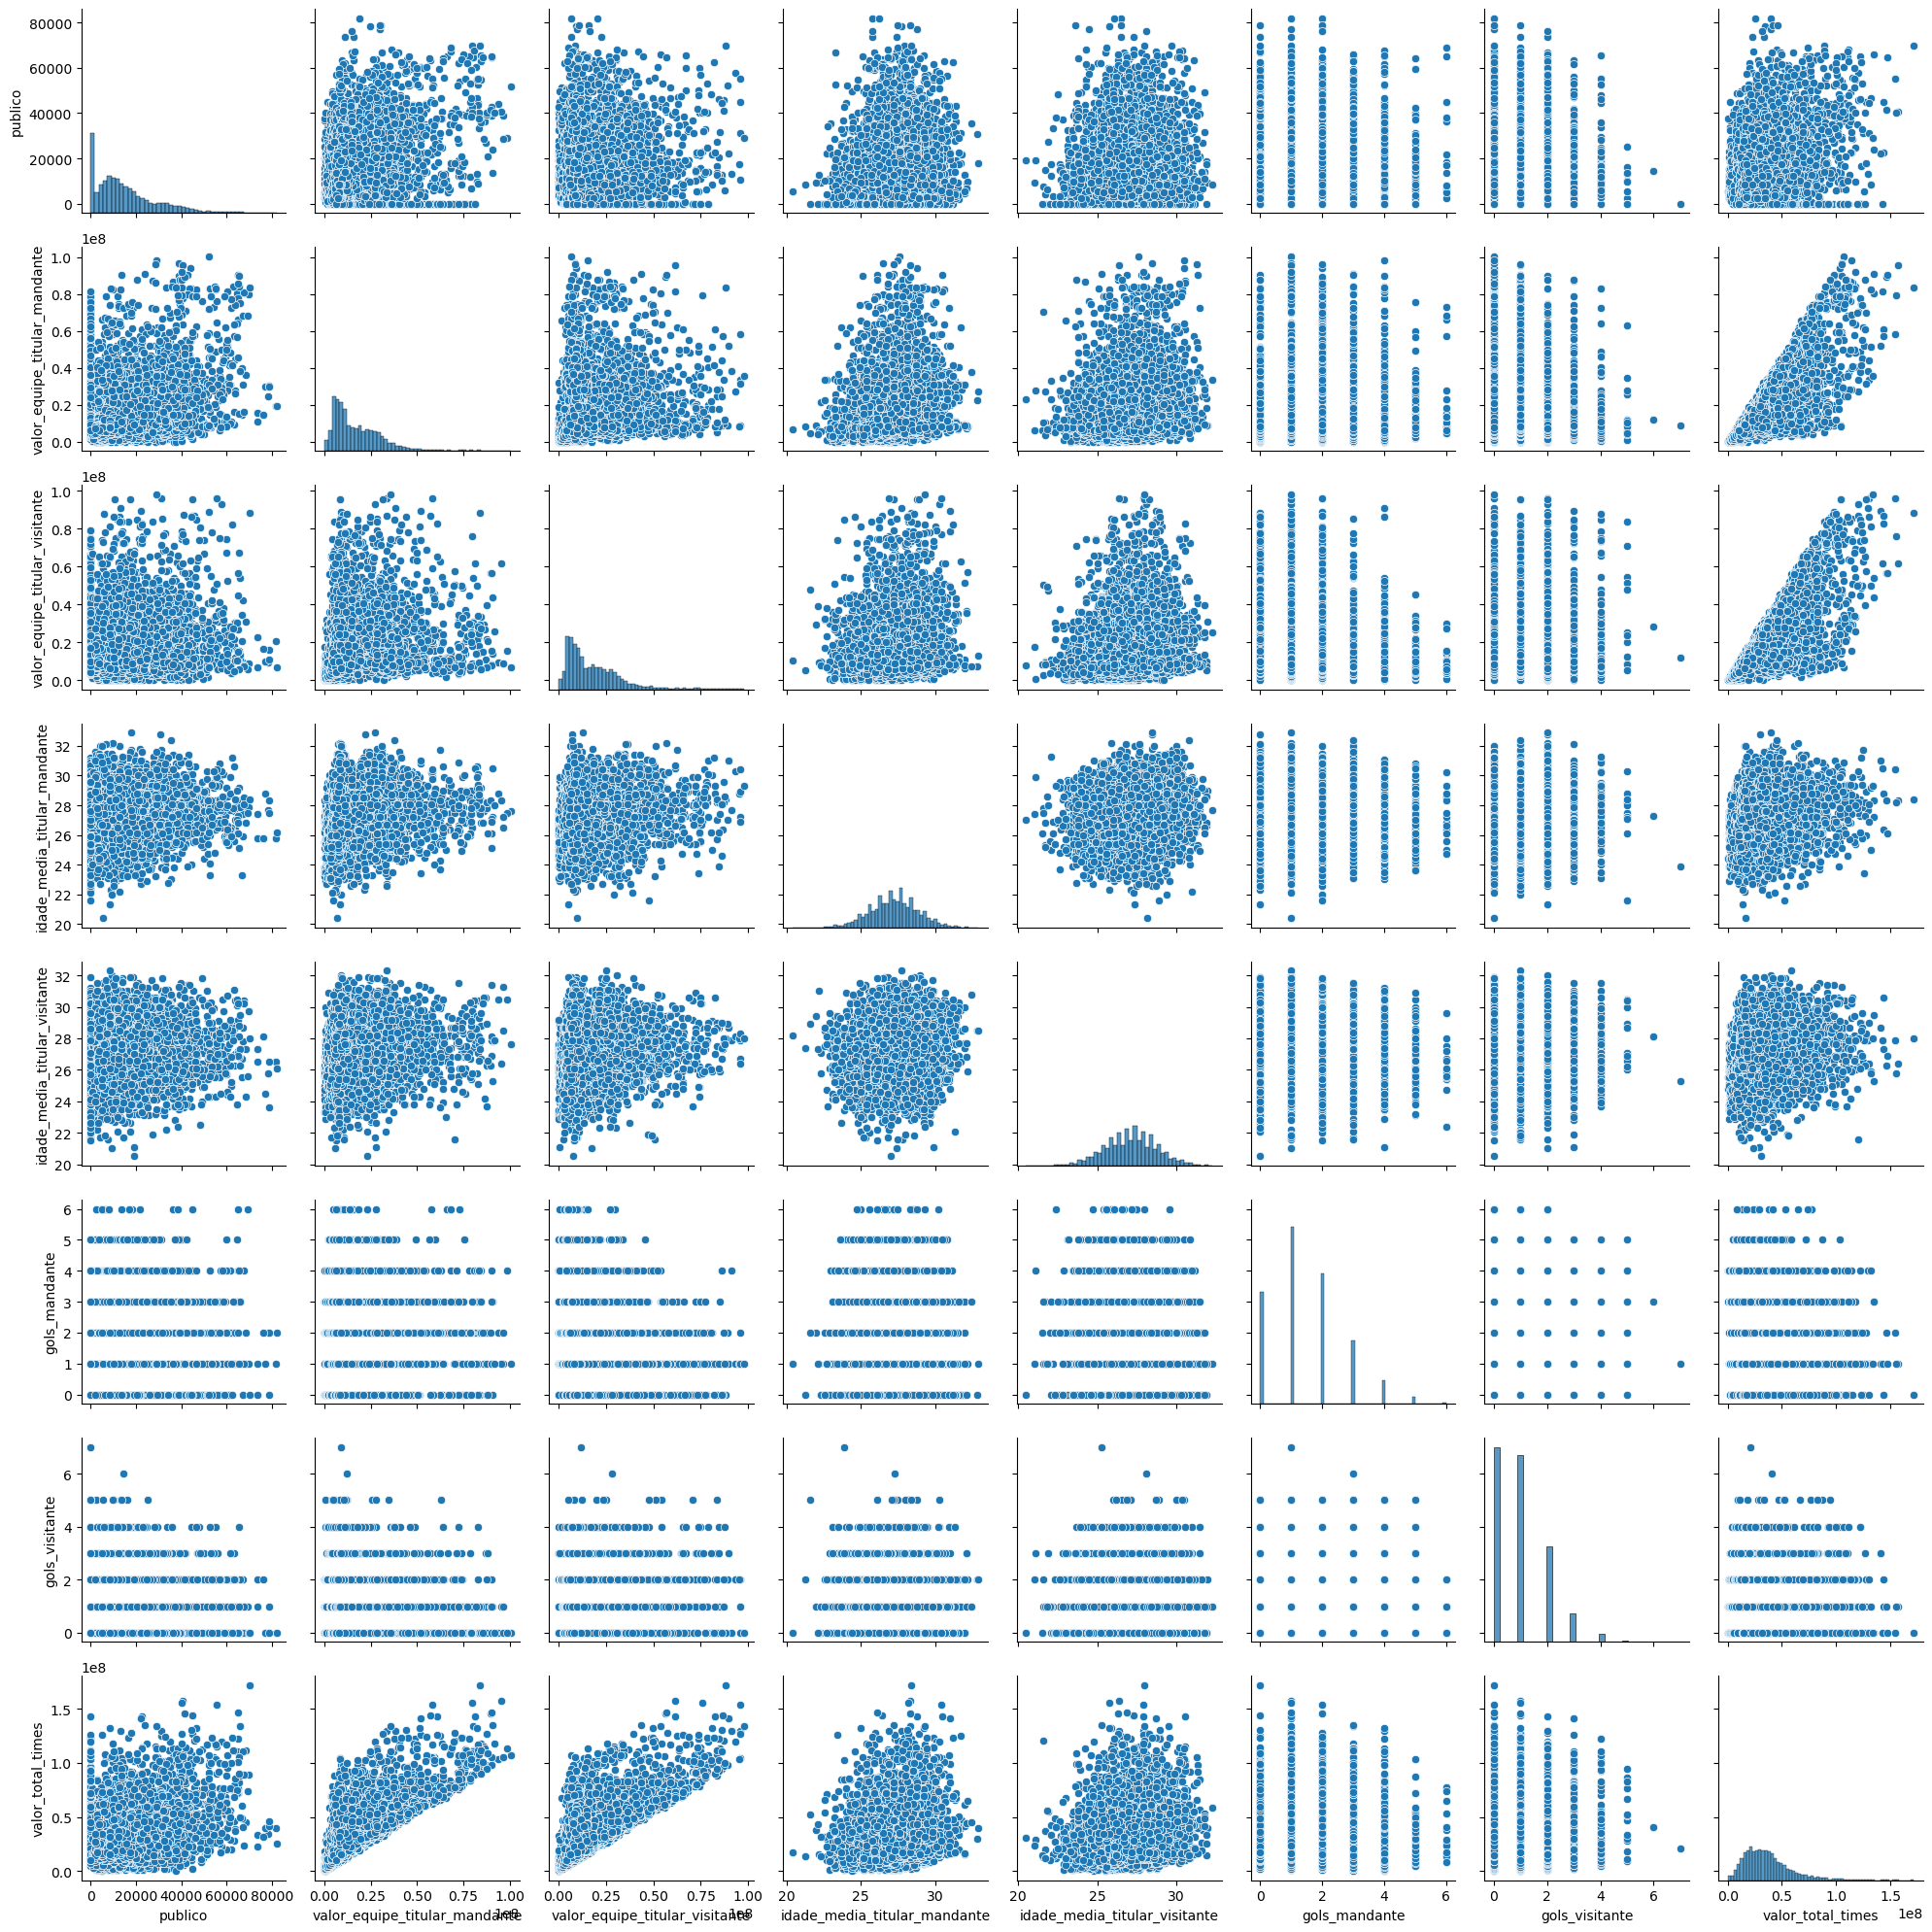

In [19]:
sns.pairplot(df_nan)
plt.tight_layout()
plt.show()

Podemos ver que o comportamento se repetiu. As variáveis dos valores de cada time com o valor total tem o comportamento de se esperar: cada time representa apenas uma parte do valor total, por isso que sua correlação é a "melhor". Porém, ela não mostra nada.

Com os dados que temos, vamos montar uma regressão com alguns dados para responder a pergunta. As variáveis explicativas selecionadas foram os valores de cada time e as idades médias de cada time.

In [33]:
Y = df_nan['publico']
X = df_nan[['valor_equipe_titular_mandante','valor_equipe_titular_visitante','idade_media_titular_mandante','idade_media_titular_visitante']]

results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                publico   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     236.8
Date:                Wed, 22 Nov 2023   Prob (F-statistic):          6.63e-189
Time:                        17:20:45   Log-Likelihood:                -64505.
No. Observations:                5931   AIC:                         1.290e+05
Df Residuals:                    5926   BIC:                         1.291e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                          -9211.5515   3825.524     -2.408      0.016   -1.67e+04   -1712.130
valor_equipe_titular_mandante      0.0003   1.13e-05     26.750      0.000       0.000       0.000
valor_equipe_titular_visitante  8.843e-05   1.18e-05      7.525      0.000    6.54e-05       0.000
idade_media_titular_mandante     599.1719    106.521      5.625      0.000     390.353     807.991
idade_media_titular_visitante     43.5255    103.539      0.420      0.674    -159.449     246.500
==============================================================================
Omnibus:                      801.888   Durbin-Watson:                   1.478
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1366.892
Skew:                           0.904   Prob(JB):                    1.52e-297
Kurtosis:                       4.504   Cond. No.                     6.99e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.99e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Com a nossa regressão, vamos realizar uma análise sobre o que ela nos mostra.

# **Análise da primeira pergunta**

É possível ver que o valor de R-squared (o valor principal que nos interessa) está baixo, com 0.138, ou seja, 13,8%. Esse número indica que os dados que foram selecionados correspondem a 13,8% das informações necessárias para compreender o crescimento e prever o público em um jogo. Mesmo tendo a teoria em mente, essa afirmação está bastante correta.

Mas por que a relação entre esses dados é tão baixa? Bom, por mais que o valor e a popularidade de cada time tenha uma certa interferência no público de cada jogo, existem outras variáveis que não foram possíveis de serem quantificadas para a nossa análise, como o estádio onde a rodada seria realizada, a rodada que corresponde ao jogo e a data. Por exemplo, jogos mais perto da final tem um público maior e estádios maiores e em cidades maiores tendem a ter um público maior.

Ou seja, relacionar o público com o valor possui uma certa relação, mas está longe de ser uma métrica que por si só consiga prever quantas pessoas estarão no estádio em um certo jogo.

Por conta disso, não é necessário nenhum método de validação ou de análise extra para ser realizado, pois análises mais qualitativas já revelam a imprecisão desse modelo.

Então, vamos partir para a próxima pergunta.

# **Montando a segunda pergunta**

Para montar nosso modelo de regressão da segunda pergunta, que é de prever quantos chutes para fora haverão em um jogo com base nas estatísticas disponíveis de cada partida, vamos primeiro pegar de novo o nosso DataFrame com as variáveis quantitativas e montar uma tabela de correlação com todos os dados.

In [35]:
df_quant = df_quant.dropna()

display(df_quant.corr())

ano_campeonato    rodada   publico  publico_max  \
ano_campeonato                1.000000 -0.239310  0.149365    -0.035595   
rodada                       -0.239310  1.000000  0.074473     0.026630   
publico                       0.149365  0.074473  1.000000     0.408415   
publico_max                  -0.035595  0.026630  0.408415     1.000000   
colocacao_mandante           -0.005710  0.003026 -0.274071    -0.326634   
...                                ...       ...       ...          ...   
impedimentos_visitante        0.125494 -0.103473 -0.001796    -0.012703   
chutes_mandante               0.522218 -0.027302 -0.028749     0.050484   
chutes_visitante              0.453700 -0.035278 -0.164563    -0.135314   
chutes_fora_mandante          0.156555 -0.012122  0.028407    -0.004491   
chutes_fora_visitante         0.075954  0.041537 -0.089138    -0.112411   

                        colocacao_mandante  colocacao_visitante  \
ano_campeonato                   -0.005710             0.011951   
rodada                            0.003026            -0.003577   
publico                          -0.274071            -0.004398   
publico_max                      -0.326634             0.023549   
colocacao_mandante                1.000000            -0.042766   
...                                    ...                  ...   
impedimentos_visitante            0.024207            -0.009915   
chutes_mandante                  -0.080342             0.128332   
chutes_visitante                  0.103447            -0.107428   
chutes_fora_mandante             -0.016790             0.103156   
chutes_fora_visitante             0.106160            -0.058686   

                        valor_equipe_titular_mandante  \
ano_campeonato                               0.199097   
rodada                                      -0.037896   
publico                                      0.386876   
publico_max                                  0.330629   
colocacao_mandante                          -0.512985   
...                                               ...   
impedimentos_visitante                      -0.030863   
chutes_mandante                              0.220440   
chutes_visitante                            -0.056017   
chutes_fora_mandante                         0.108948   
chutes_fora_visitante                       -0.128452   

                        valor_equipe_titular_visitante  \
ano_campeonato                                0.213382   
rodada                                       -0.041373   
publico                                       0.142117   
publico_max                                  -0.022015   
colocacao_mandante                            0.002219   
...                                                ...   
impedimentos_visitante                        0.032705   
chutes_mandante                              -0.050623   
chutes_visitante                              0.203092   
chutes_fora_mandante                         -0.115514   
chutes_fora_visitante                         0.088024   

                        idade_media_titular_mandante  \
ano_campeonato                              0.059426   
rodada                                      0.004440   
publico                                     0.187778   
publico_max                                 0.210469   
colocacao_mandante                         -0.053975   
...                                              ...   
impedimentos_visitante                     -0.006560   
chutes_mandante                             0.018563   
chutes_visitante                           -0.036346   
chutes_fora_mandante                        0.024763   
chutes_fora_visitante                      -0.059627   

                        idade_media_titular_visitante  ...  \
ano_campeonato                               0.078093  ...   
rodada                                      -0.036091  ...   
publico                                      0.085334  ...   
publico_max    

In [22]:
df_quant.dtypes

ano_campeonato              int64
rodada                      int64
publico                   float64
publico_max               float64
colocacao_mandante        float64
                           ...   
impedimentos_visitante    float64
chutes_mandante           float64
chutes_visitante          float64
chutes_fora_mandante      float64
chutes_fora_visitante     float64
Length: 28, dtype: object

Para obter as métricas de uma partida, vamos apenas selecionar um intervalo de colunas, mais especificamente da 10a coluna em diante.

In [23]:
df_matchstats = df_quant.iloc[:, 10:]
df_matchstats

gols_mandante  gols_visitante  gols_1_tempo_mandante  \
6058            0.0             0.0                    0.0   
6060            1.0             0.0                    1.0   
6061            2.0             1.0                    0.0   
6062            1.0             1.0                    0.0   
6059            3.0             1.0                    1.0   
...             ...             ...                    ...   
8029            2.0             1.0                    2.0   
8030            3.0             0.0                    0.0   
8031            1.0             0.0                    0.0   
8032            2.0             1.0                    2.0   
8033            1.0             1.0                    1.0   

      gols_1_tempo_visitante  escanteios_mandante  escanteios_visitante  \
6058                     0.0                  3.0                   9.0   
6060                     0.0                  5.0                   2.0   
6061                     1.0                  7.0                   5.0   
6062                     0.0                  4.0                   4.0   
6059                     1.0                  3.0                   4.0   
...                      ...                  ...                   ...   
8029                     1.0                  4.0                   3.0   
8030                     0.0                  7.0                   0.0   
8031                     0.0                 12.0                   2.0   
8032                     1.0                 11.0                   4.0   
8033                     0.0                  3.0                   7.0   

      faltas_mandante  faltas_visitante  chutes_bola_parada_mandante  \
6058             15.0              15.0                         15.0   
6060             29.0              17.0                         19.0   
6061             15.0              20.0                         21.0   
6062             11.0               9.0                          2.0   
6059             17.0               8.0                          1.0   
...               ...               ...                          ...   
8029             12.0              12.0                         11.0   
8030             18.0              12.0                         11.0   
8031             11.0              13.0                         13.0   
8032             14.0              14.0                         14.0   
8033             10.0              12.0                         10.0   

      chutes_bola_parada_visitante  defesas_mandante  defesas_visitante  \
6058                          15.0               3.0                4.0   
6060                          30.0               2.0                3.0   
6061                          16.0               3.0                3.0   
6062                           2.0               0.0                0.0   
6059                           1.0               1.0                1.0   
...                            ...               ...                ...   
8029                          12.0               1.0                3.0   
8030                          16.0               2.0                3.0   
8031                          11.0               4.0                4.0   
8032                          11.0               1.0                6.0   
8033                          10.0               3.0                5.0   

      impedimentos_mandante  impedimentos_visitante  chutes_mandante  \
6058                    0.0                     0.0              4.0   
6060                    1.0                     2.0              4.0   
6061                    1.0                     1.0              5.0   
6062                    2.0                     2.0              1.0   
6059                    1.0                     1.0              4.0   
...                     ...                     ...              ...   
8029                    2.0                     0.0             14.0   
8030              

Para analisar visualmente os comportamentos de correlação, iremos plotar um Seaborn com **todas** as variáveis de estatísticas da partida.

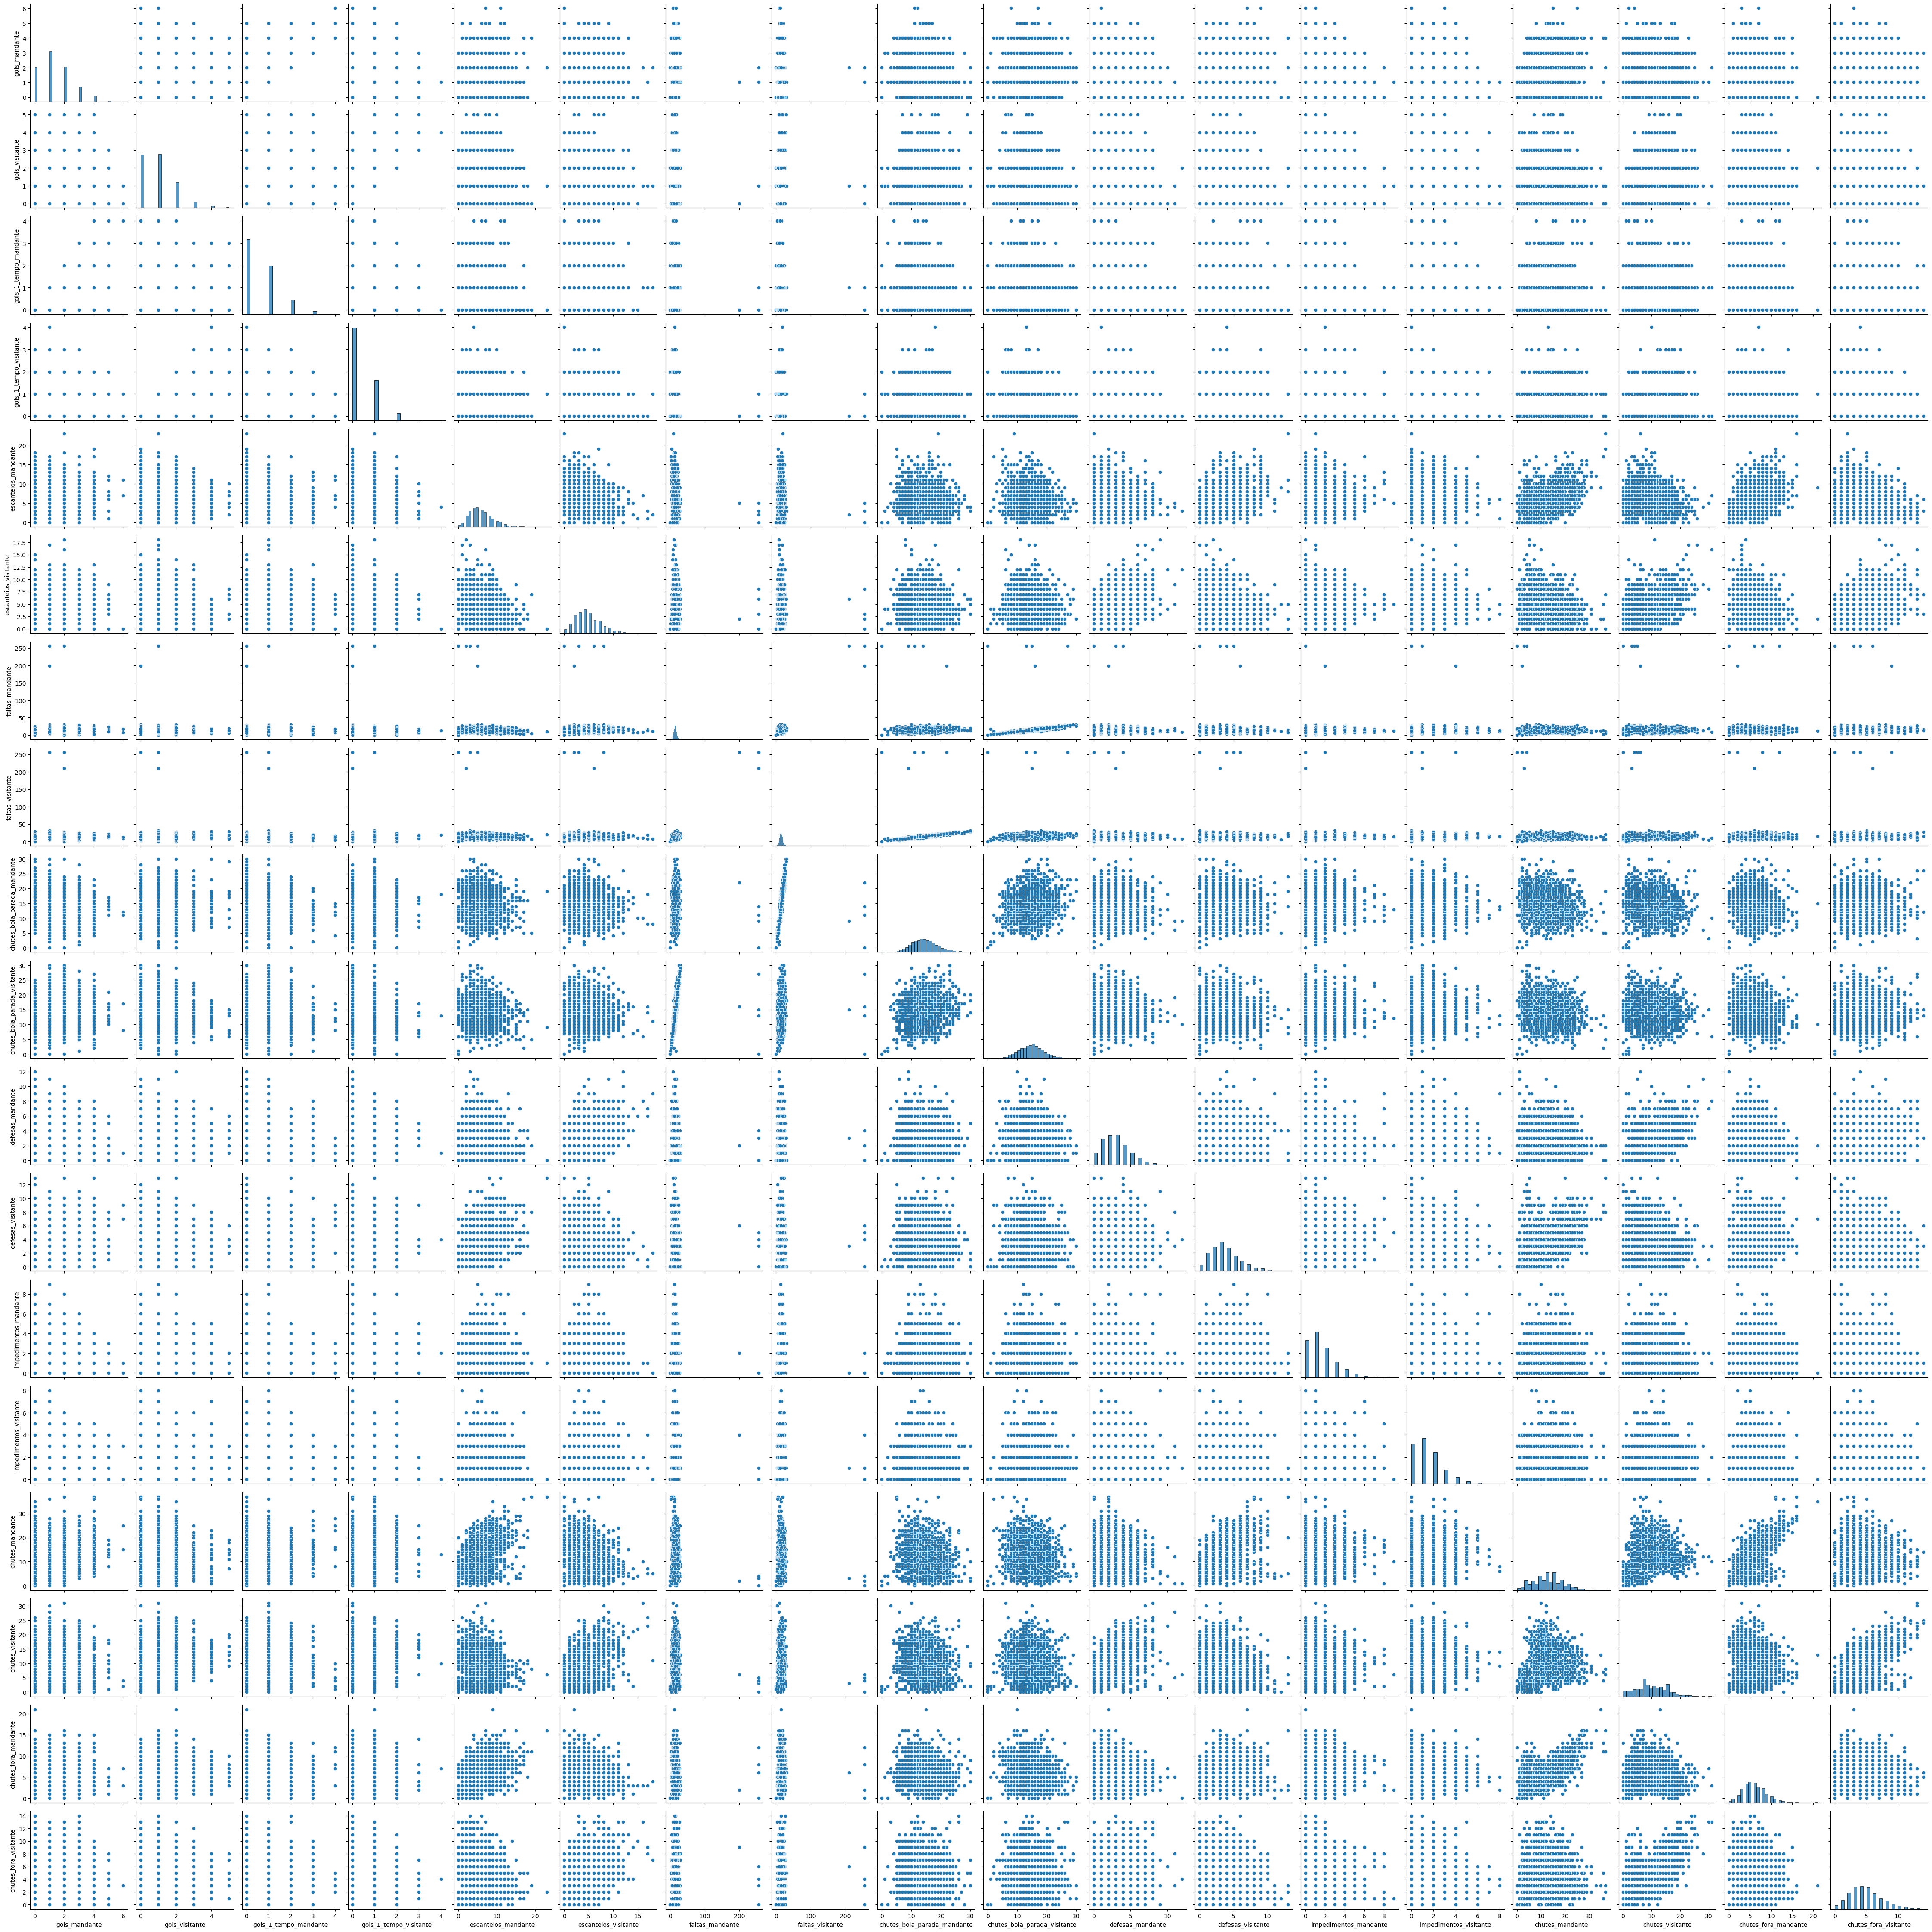

In [24]:
sns.pairplot(df_matchstats)
plt.tight_layout()
plt.show()

Bom, o que podemos traçar dessa tabela gigantesca de gráficos? Para início, analisar visualmente as correlações é mais fácil do que puxar uma tabela gigante com números, mas mesmo assim temos bastante dados. Então, precisaremos traçar cada gráfico com as variáveis correspondentes.

Podemos ver que os gráficos mais ao canto inferior direito possuem uma maior correlação, e são os dados que relacionam faltas, chutes e defesas com os chutes para fora. Ou seja, existe uma certa correlação entre esses dados.

Será necessário montar duas regressões para responder nossa pergunta: uma para os times mandantes e outra para os visitantes.

Para fazer uma análise que faça sentido, foram priorizados dados que fariam o time ter uma vantagem sobre a bola ou de errar o chute. Isso inclui, então, as faltas do outro time, gols, escanteios, defesas do time adversário, impedimentos e chutes totais.

Portanto, vamos selecionar esses dados para o time mandante primeiro.

# Time mandante

In [25]:
Y = df_matchstats['chutes_fora_mandante']
X = df_matchstats[['gols_mandante','escanteios_mandante','faltas_visitante','chutes_bola_parada_mandante','defesas_visitante','impedimentos_visitante','chutes_mandante','chutes_visitante','defesas_mandante']]

results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     chutes_fora_mandante   R-squared:                       0.508
Model:                              OLS   Adj. R-squared:                  0.506
Method:                   Least Squares   F-statistic:                     195.8
Date:                  Wed, 22 Nov 2023   Prob (F-statistic):          2.84e-255
Time:                          16:31:22   Log-Likelihood:                -3604.5
No. Observations:                  1714   AIC:                             7229.
Df Residuals:                      1704   BIC:                             7284.
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           3.8902      0.261     14.928      0.000       3.379       4.401
gols_mandante                  -0.4732      0.044    -10.834      0.000      -0.559      -0.388
escanteios_mandante             0.0603      0.018      3.348      0.001       0.025       0.096
faltas_visitante                0.0107      0.004      2.821      0.005       0.003       0.018
chutes_bola_parada_mandante    -0.0053      0.011     -0.467      0.640      -0.028       0.017
defesas_visitante              -0.3202      0.026    -12.117      0.000      -0.372      -0.268
impedimentos_visitante         -0.1021      0.036     -2.806      0.005      -0.174      -0.031
chutes_mandante                 0.3692      0.011     35.095      0.000       0.349       0.390
chutes_visitante               -0.1623      0.012    -13.492      0.000      -0.186      -0.139
defesas_mandante                0.1677      0.030      5.500      0.000       0.108       0.228
==============================================================================
Omnibus:                       89.225   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.732
Skew:                           0.499   Prob(JB):                     7.40e-26
Kurtosis:                       3.791   Cond. No.                         156.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Com os dados iniciais, foi obtido um R-squared de 0.508, ou seja, existe uma boa correlação entre esses dados. Portanto, para melhorar a análise e permitir um modelo reduzido mas que explica bem os dados, vamos remover as variáveis com um valor-p (P>|t| na tabela) maior que 0.1.

Esse método é chamado de Backward Stepwise, um método que pega um modelo inicialmente saturado de dados e vai removendo aos poucos variáveis para que haja uma boa compreensão dos dados, mantendo um mesmo valor ou suficientemente próximo de R-squared. 

In [46]:
Y = df_matchstats['chutes_fora_mandante']
X = df_matchstats[['gols_mandante','escanteios_mandante','faltas_visitante','defesas_visitante','impedimentos_visitante','chutes_mandante','chutes_visitante','defesas_mandante']]

results_mandante = regress(Y,X)
results_mandante.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     chutes_fora_mandante   R-squared:                       0.508
Model:                              OLS   Adj. R-squared:                  0.506
Method:                   Least Squares   F-statistic:                     220.3
Date:                  Thu, 23 Nov 2023   Prob (F-statistic):          2.07e-256
Time:                          14:59:30   Log-Likelihood:                -3604.7
No. Observations:                  1714   AIC:                             7227.
Df Residuals:                      1705   BIC:                             7276.
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3.8128      0.201     18.950      0.000       3.418       4.207
gols_mandante             -0.4714      0.043    -10.838      0.000      -0.557      -0.386
escanteios_mandante        0.0604      0.018      3.354      0.001       0.025       0.096
faltas_visitante           0.0102      0.004      2.798      0.005       0.003       0.017
defesas_visitante         -0.3206      0.026    -12.144      0.000      -0.372      -0.269
impedimentos_visitante    -0.1028      0.036     -2.828      0.005      -0.174      -0.032
chutes_mandante            0.3697      0.010     35.284      0.000       0.349       0.390
chutes_visitante          -0.1620      0.012    -13.490      0.000      -0.186      -0.138
defesas_mandante           0.1679      0.030      5.506      0.000       0.108       0.228
==============================================================================
Omnibus:                       90.771   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.011
Skew:                           0.504   Prob(JB):                     2.37e-26
Kurtosis:                       3.798   Cond. No.                         107.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

No geral, podemos ver que o nosso R-squared se manteve na faixa de 0.508, o que mostra que temos aproximadamente 51% dos dados necessários para os chutes para fora dos times mandantes.

# Time visitante

O mesmo processo feito para o time mandante é repetido para o time visitante.

In [27]:
Y = df_matchstats['chutes_fora_visitante']
X = df_matchstats[['gols_visitante','escanteios_visitante','faltas_mandante','chutes_bola_parada_visitante','defesas_mandante','impedimentos_mandante','chutes_mandante','chutes_visitante','defesas_visitante']]

results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     chutes_fora_visitante   R-squared:                       0.531
Model:                               OLS   Adj. R-squared:                  0.528
Method:                    Least Squares   F-statistic:                     214.3
Date:                   Wed, 22 Nov 2023   Prob (F-statistic):          1.27e-272
Time:                           16:31:22   Log-Likelihood:                -3385.9
No. Observations:                   1714   AIC:                             6792.
Df Residuals:                       1704   BIC:                             6846.
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            2.9733      0.230     12.940      0.000       2.523       3.424
gols_visitante                  -0.5138      0.045    -11.331      0.000      -0.603      -0.425
escanteios_visitante             0.0332      0.019      1.778      0.076      -0.003       0.070
faltas_mandante                 -0.0009      0.003     -0.251      0.802      -0.008       0.006
chutes_bola_parada_visitante     0.0079      0.010      0.771      0.441      -0.012       0.028
defesas_mandante                -0.3562      0.027    -13.213      0.000      -0.409      -0.303
impedimentos_mandante           -0.0891      0.030     -2.956      0.003      -0.148      -0.030
chutes_mandante                 -0.1308      0.009    -14.896      0.000      -0.148      -0.114
chutes_visitante                 0.4191      0.011     37.772      0.000       0.397       0.441
defesas_visitante                0.1538      0.023      6.651      0.000       0.108       0.199
==============================================================================
Omnibus:                      177.618   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              313.766
Skew:                           0.697   Prob(JB):                     7.35e-69
Kurtosis:                       4.564   Cond. No.                         157.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
Y = df_matchstats['chutes_fora_visitante']
X = df_matchstats[['gols_visitante','escanteios_visitante','chutes_bola_parada_visitante','defesas_mandante','impedimentos_mandante','chutes_mandante','chutes_visitante','defesas_visitante']]

results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     chutes_fora_visitante   R-squared:                       0.531
Model:                               OLS   Adj. R-squared:                  0.529
Method:                    Least Squares   F-statistic:                     241.2
Date:                   Wed, 22 Nov 2023   Prob (F-statistic):          8.20e-274
Time:                           16:31:22   Log-Likelihood:                -3385.9
No. Observations:                   1714   AIC:                             6790.
Df Residuals:                       1705   BIC:                             6839.
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            2.9679      0.229     12.977      0.000       2.519       3.416
gols_visitante                  -0.5137      0.045    -11.333      0.000      -0.603      -0.425
escanteios_visitante             0.0333      0.019      1.784      0.075      -0.003       0.070
chutes_bola_parada_visitante     0.0071      0.010      0.730      0.466      -0.012       0.026
defesas_mandante                -0.3559      0.027    -13.218      0.000      -0.409      -0.303
impedimentos_mandante           -0.0886      0.030     -2.948      0.003      -0.148      -0.030
chutes_mandante                 -0.1307      0.009    -14.920      0.000      -0.148      -0.113
chutes_visitante                 0.4190      0.011     37.784      0.000       0.397       0.441
defesas_visitante                0.1537      0.023      6.649      0.000       0.108       0.199
==============================================================================
Omnibus:                      177.702   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              314.191
Skew:                           0.697   Prob(JB):                     5.95e-69
Kurtosis:                       4.566   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
Y = df_matchstats['chutes_fora_visitante']
X = df_matchstats[['gols_visitante','escanteios_visitante','defesas_mandante','impedimentos_mandante','chutes_mandante','chutes_visitante','defesas_visitante']]

results_visitante = regress(Y,X)
results_visitante.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     chutes_fora_visitante   R-squared:                       0.531
Model:                               OLS   Adj. R-squared:                  0.529
Method:                    Least Squares   F-statistic:                     275.7
Date:                   Thu, 23 Nov 2023   Prob (F-statistic):          6.21e-275
Time:                           14:59:21   Log-Likelihood:                -3386.2
No. Observations:                   1714   AIC:                             6788.
Df Residuals:                       1706   BIC:                             6832.
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.0850      0.163     18.943      0.000       2.766       3.404
gols_visitante           -0.5164      0.045    -11.430      0.000      -0.605      -0.428
escanteios_visitante      0.0325      0.019      1.742      0.082      -0.004       0.069
defesas_mandante         -0.3560      0.027    -13.226      0.000      -0.409      -0.303
impedimentos_mandante    -0.0881      0.030     -2.932      0.003      -0.147      -0.029
chutes_mandante          -0.1317      0.009    -15.219      0.000      -0.149      -0.115
chutes_visitante          0.4191      0.011     37.796      0.000       0.397       0.441
defesas_visitante         0.1544      0.023      6.691      0.000       0.109       0.200
==============================================================================
Omnibus:                      177.721   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              315.012
Skew:                           0.697   Prob(JB):                     3.94e-69
Kurtosis:                       4.572   Cond. No.                         72.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Ao final, vemos que o time visitante possui um R-squared de 0.531, um pouco maior que o time mandante, mas próximo o suficiente para uma análise qualitativa desses dois modelos.

# **Transformando as variáveis explicativas em PCA**

Em ambos os casos dos chutes para fora, existem várias variáveis. Para que seja possível plotar todos esses dados como foram vistos em sala de aula, será necessário transformar todas as variáveis em apenas duas.

Um método possível de fazer isso pode ser por alterar o DataFrame manualmente, criando uma nova tabela e simplificando as colunas com nossas variáveis. Porém, nesse processo, valores podem ser perdidos e análises estatísticas também. Portanto, utilizaremos outro método, o **PCA**.

O PCA (Principal Component Analysis) é um método que, a grosso modo, reduz a dimensão dos nossos dados linearmente para poder compreender o comportamento de tais no nosso modelo. Ou seja, esse método destrói os nossos dados mas permite uma compreensão melhor visual entre as variáveis do nosso modelo.

Para começar o processo, iremos filtrar o DataFrame de estatísticas das partidas para obter dois diferentes com as variáveis explicativas desejadas: um para os mandantes e outra para os visitantes.

In [37]:
df_mandante = df_matchstats.loc[:, ['gols_mandante','escanteios_mandante','faltas_visitante','defesas_visitante','impedimentos_visitante','chutes_mandante','chutes_visitante','defesas_mandante']]

df_mandante

gols_mandante  escanteios_mandante  faltas_visitante  defesas_visitante  \
6058            0.0                  3.0              15.0                4.0   
6060            1.0                  5.0              17.0                3.0   
6061            2.0                  7.0              20.0                3.0   
6062            1.0                  4.0               9.0                0.0   
6059            3.0                  3.0               8.0                1.0   
...             ...                  ...               ...                ...   
8029            2.0                  4.0              12.0                3.0   
8030            3.0                  7.0              12.0                3.0   
8031            1.0                 12.0              13.0                4.0   
8032            2.0                 11.0              14.0                6.0   
8033            1.0                  3.0              12.0                5.0   

      impedimentos_visitante  chutes_mandante  chutes_visitante  \
6058                     0.0              4.0               3.0   
6060                     2.0              4.0               2.0   
6061                     1.0              5.0               4.0   
6062                     2.0              1.0               2.0   
6059                     1.0              4.0               1.0   
...                      ...              ...               ...   
8029                     0.0             14.0               7.0   
8030                     3.0             17.0               7.0   
8031                     3.0             15.0               6.0   
8032                     1.0             22.0               6.0   
8033                     1.0             18.0              15.0   

      defesas_mandante  
6058               3.0  
6060               2.0  
6061               3.0  
6062               0.0  
6059               1.0  
...                ...  
8029               1.0  
8030               2.0  
8031               4.0  
8032               1.0  
8033               3.0  

[1714 rows x 8 columns]

Agora, iremos realizar o PCA com as variáveis finais do modelo de regressão dos times mandantes.

In [80]:
pca = PCA(n_components=2)
new_mandante = pca.fit_transform(df_mandante,y=None)

i = 0
x1 = []
x2 = []
while i < len(new_mandante):
    x1.append(new_mandante[i][0])
    x2.append(new_mandante[i][1])
    i+=1

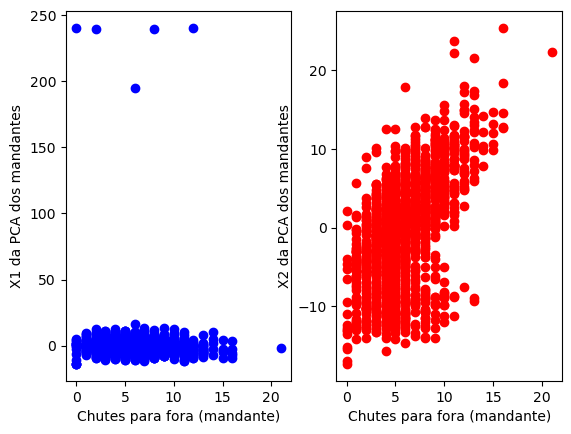

In [81]:
fig, (s1,s2) = plt.subplots(1,2)
s1.scatter(df_matchstats['chutes_fora_mandante'],x1,c='blue')
s2.scatter(df_matchstats['chutes_fora_mandante'],x2,c='red')
s1.set_xlabel('Chutes para fora (mandante)')
s1.set_ylabel('X1 da PCA dos mandantes')
s2.set_xlabel('Chutes para fora (mandante)')
s2.set_ylabel('X2 da PCA dos mandantes')
plt.show()

Este gráfico permite visualizar a correlação entre as duas variáveis resultantes do PCA (X1 e X2). Porém, não é possível compreender exatamente o que esses gráficos estão nos mostrando. 

Para que uma PCA seja utilizada devidamente, a sua análise gráfica deve ser feita entre suas duas variáveis. Isso permite que a compreensão entre os dados e a variável selecionada seja melhor e efetiva. Caso contrário, os dados foram destruídos para efetivamente nada.

Portanto, vamos montar um scatter chart com nossas duas variáveis da PCA, usando um espectro de cor onde, quanto mais próximo do amarelo, maior é o valor da variável.

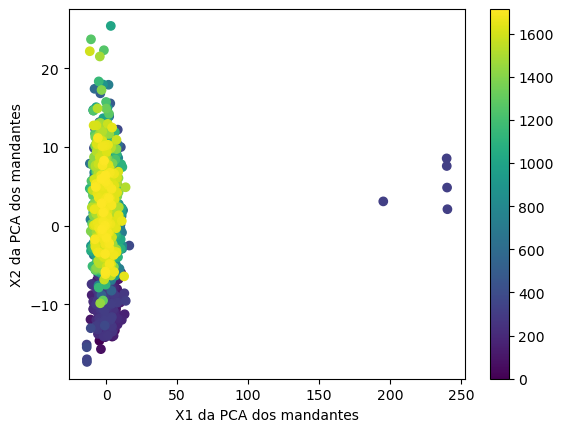

In [83]:
colors = [*range(0, 1714, 1)]

plt.scatter(x1,x2,c=colors, vmin=0, vmax=1714, cmap="viridis")
plt.xlabel('X1 da PCA dos mandantes')
plt.ylabel('X2 da PCA dos mandantes')
plt.colorbar()
plt.show()

Bom... O que está acontecendo aqui?

Para compreender melhor, vamos fazer a mesma coisa com os dados dos visitantes.

In [84]:
df_visitante = df_matchstats.loc[:, ['gols_visitante','escanteios_visitante','defesas_mandante','impedimentos_mandante','chutes_mandante','chutes_visitante','defesas_visitante']]

pca = PCA(n_components=2)
new_visitante = pca.fit_transform(df_visitante, y=None)

i = 0
x1 = []
x2 = []
while i < len(new_visitante):
    x1.append(new_visitante[i][0])
    x2.append(new_visitante[i][1])
    i+=1

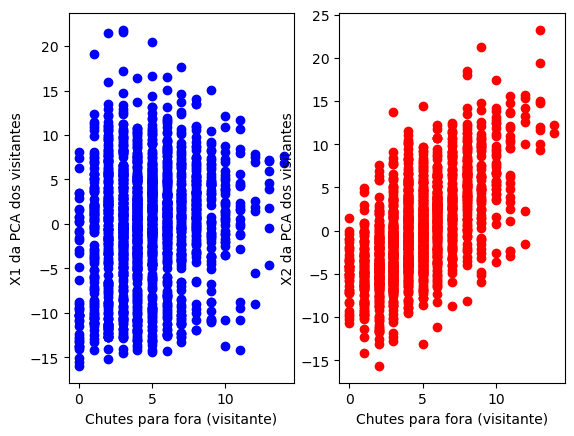

In [85]:
fig, (s1,s2) = plt.subplots(1,2)
s1.scatter(df_matchstats['chutes_fora_visitante'],x1,c='blue')
s2.scatter(df_matchstats['chutes_fora_visitante'],x2,c='red')
s1.set_xlabel('Chutes para fora (visitante)')
s1.set_ylabel('X1 da PCA dos visitantes')
s2.set_xlabel('Chutes para fora (visitante)')
s2.set_ylabel('X2 da PCA dos visitantes')
plt.show()

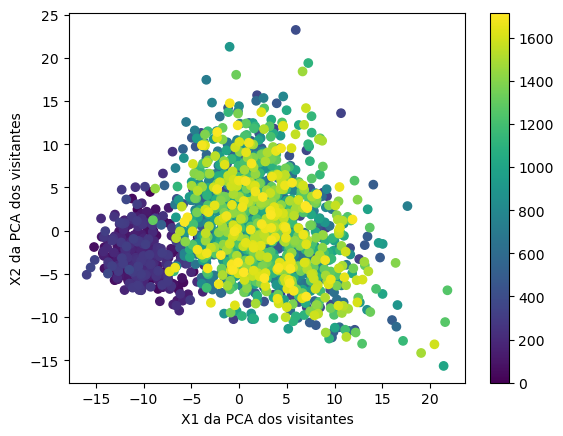

In [86]:
colors = [*range(0, 1714, 1)]

plt.scatter(x1,x2,c=colors, vmin=0, vmax=1714, cmap="viridis")
plt.xlabel('X1 da PCA dos visitantes')
plt.ylabel('X2 da PCA dos visitantes')
plt.colorbar()
plt.show()

Bem diferente do primeiro, né? Porém, ambos possuem uma similaridade: a concentração de dados em um ponto.

# **Análise da segunda pergunta**

Com os gráficos entre as variáveis de cada PCA, é possível concluir que, por mais que o nosso modelo tenha um R-squared bem maior que a primeira pergunta, ele não é bom o suficiente para prever os chutes.

Utilizando os dois gráficos da PCA para explicar esse comportamento, é possível notar que os dados não estão distribuídos com uma boa correlação, seja positiva ou negativa. Todos estão concentrados em um ponto ou linha central: no primeiro gráfico, é próximo da reta x = 0 e, no segundo, na região central, perto também da reta x = 0.

Isso nos mostra que o nosso modelo não é uma referência boa para prever os chutes para fora considerando as nossas variáveis como explicativas, dado que, com o PCA para melhor visualização, as variáveis estão bastante concentradas em um único ponto, mostrando diversos outliers em relação à um comportamento de reta dos chutes para fora.

Mas o que isso significa em uma análise mais qualitativa dos nossos dados e do nosso modelo?

Bom, existem diversas coisas a se considerar para analisar a quantidade de chutes para fora em um jogo. Em termos quantitativos, podemos citar a quantia de torcedores de cada time, a rodada atual, tempo de treino, etc. Porém, esses dados acabam se relacionando diretamente com informações que não podem ser quantificadas, como pressão, moral do time, condições climáticas, etc.

Portanto, nosso modelo é falho por conta de questões que não são possíveis de serem medidas quantitativamente.

# **Conclusão**

Ambas as perguntas mostraram que existe, possivelmente, uma falta de dados. A regressão do modelo do público poderia ter sido mais precisa se dados como datas, público máximo no estádio, ingressos disponíveis, entre outros, estivessem disponíveis. Porém, ambos os resultados partem do princípio de que há dados essenciais para o compreendimento de ambas as perguntas que não podem ser quantificados.

No caso da primeira pergunta, temos toda uma questão de época, diretoria do time, possíveis recentes controvérsias, entre outros. E na segunda, temos diversas questões de moral do time, local, treino, pressão.

Esse comportamento pode ser visto em diversos aspectos das estatísticas e dos resultados dos jogos de futebol. Por exemplo, como que o Brasil, após um ótimo jogo, é eliminado da Copa do Mundo por um 7x1? Como que um time como o Corinthians, um dos maiores do Brasil, perde de 5x1 para o Bahia, que é um time bem menor?

Esses e outros são dados que não podem ser exatamente quantificados sem que haja uma grande disparidade e imprecisão no modelo.

Talvez a maneira com que realizamos a regressão possa não ter sido adequada.

Ou, possivelmente, essa seja a magia do futebol brasileiro.

# **Referências**

- [Documentação sobre a biblioteca do SciKit Learn sobre PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [Explicação sobre Backward Stepwise](https://www.analystsoft.com/en/products/statplus/content/help/pdf/analysis_regression_backward_stepwise_elimination_regression_model.pdf)
- [Link para a base de dados selecionada](https://basedosdados.org/dataset/c861330e-bca2-474d-9073-bc70744a1b23?table=18835b0d-233e-4857-b454-1fa34a81b4fa)